# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.pipeline import Pipeline 
import time

# 2. Load Dataset

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


# 3. EDA

In [3]:
df.shape

(878049, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [6]:
# check for duplicated values
df.duplicated().sum()

2323

In [7]:
# remove duplicated records
df.drop_duplicates(keep = 'first', inplace = True)

In [8]:
df.shape

(875726, 9)

In [10]:
df.nunique()

Dates         389257
Category          39
Descript         879
DayOfWeek          7
PdDistrict        10
Resolution        17
Address        23228
X              34243
Y              34243
dtype: int64

In [11]:
# there are 39 categories of crime to be classified
df.Category.value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

In [29]:
# keeping a copy of raw data
df1 = df.copy()

In [30]:
# extracting the info of day, week, month, year from date

df1['Dates'] = pd.to_datetime(df1['Dates'])
df1['Year'] = df1['Dates'].dt.year
df1['Month'] = df1['Dates'].dt.month
df1['Day_Month'] = df1['Dates'].dt.day
df1['Day_Week'] = df1['Dates'].dt.day_of_week
df1['Hour'] = df1['Dates'].dt.hour
df1.drop(['Dates', 'DayOfWeek'], axis = 1, inplace = True)
df1.dtypes

Category       object
Descript       object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Year            int64
Month           int64
Day_Month       int64
Day_Week        int64
Hour            int64
dtype: object

In [31]:
df1.head()

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_Month,Day_Week,Hour
0,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,2,23
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,2,23
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,2,23
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,2,23
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,2,23


In [32]:
df1.shape

(875726, 12)

In [33]:
df1.columns

Index(['Category', 'Descript', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y',
       'Year', 'Month', 'Day_Month', 'Day_Week', 'Hour'],
      dtype='object')

In [34]:
pd.crosstab(df1['Day_Week'],df1['Category'])

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Day_Week,,,,,,,,,,,,,,,,,,,,,
0,228,10550,66,41,5239,607,263,7812,512,222,...,23,636,75,4445,1,1080,5916,7401,5804,1182
1,235,10268,76,37,5356,657,251,8463,461,156,...,23,713,66,4513,1,1113,5844,7262,6412,1176
2,200,10549,71,40,5430,658,221,9259,541,165,...,22,699,66,4849,0,1120,5904,7393,7009,1251
3,199,10236,66,39,5336,643,282,8447,496,165,...,15,678,89,4504,1,1046,5968,7449,6365,1281
4,220,11155,62,49,6302,540,352,7415,621,211,...,28,647,72,4921,1,1062,7071,8597,5921,1302
5,219,11987,45,42,4732,624,457,6385,833,137,...,21,581,73,4154,2,982,7301,8108,5355,1231
6,211,12070,20,41,4205,584,442,6138,813,108,...,16,583,67,4008,0,915,6577,7496,5279,1127


In [35]:
categories_df = df1.Category.value_counts().to_frame().reset_index()
top_crimes = categories_df.iloc[:10]
top_crimes

,index,Category
0,LARCENY/THEFT,174320
1,OTHER OFFENSES,125960
2,NON-CRIMINAL,91915
3,ASSAULT,76815
4,DRUG/NARCOTIC,53919
5,VEHICLE THEFT,53706
6,VANDALISM,44581
7,WARRANTS,42145
8,BURGLARY,36600
9,SUSPICIOUS OCC,31394


In [42]:
hour_df = df1.Hour.value_counts().to_frame().sort_index()
hour_df.head()

,Hour
0,44684
1,26125
2,22261
3,13988
4,9848


In [40]:
dayweek_df = df1.Day_Week.value_counts().to_frame().sort_index()
dayweek_df

,Day_Week
0,121303
1,124603
2,128829
3,124757
4,133371
5,126469
6,116394


In [43]:
%matplotlib inline

Text(0.5, 1.0, 'Crime - Hourly data')

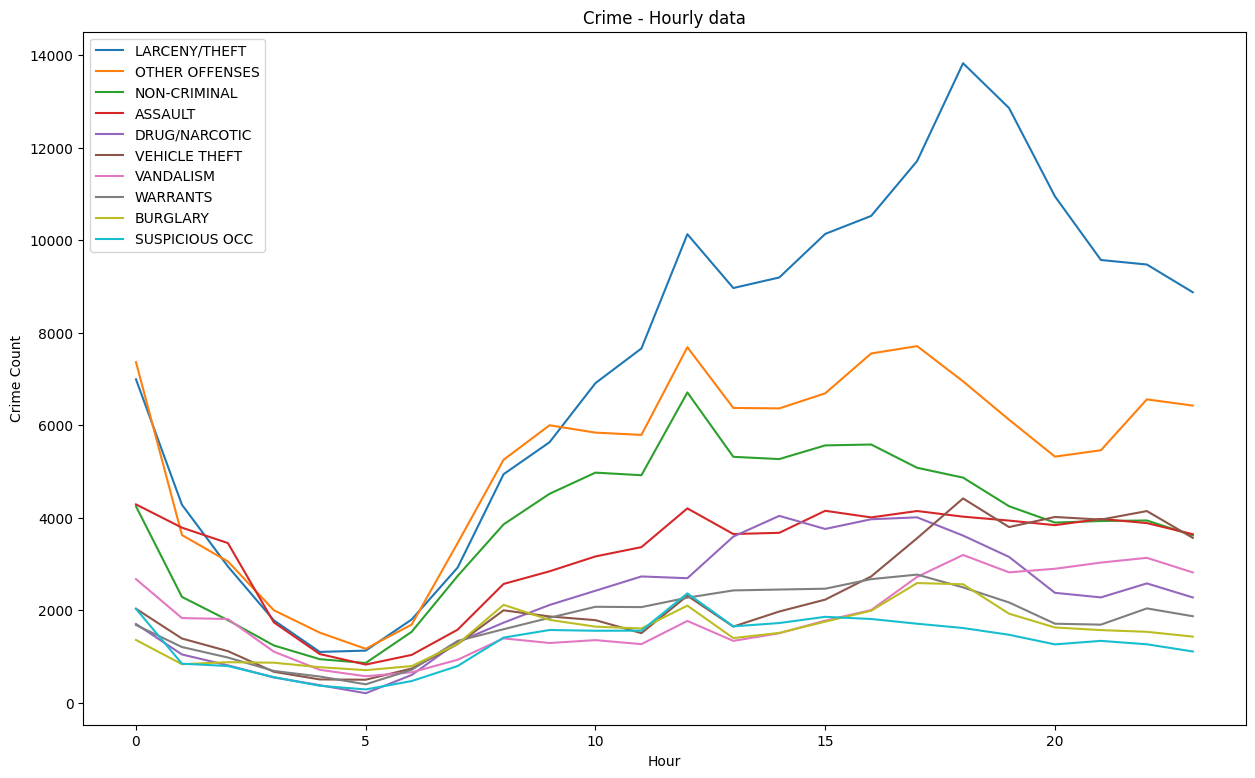

In [51]:
plt.figure(figsize = (15,9))

for crime in top_crimes['index']:
    df_cat = df1[df1.Category == crime].Hour.value_counts().to_frame().sort_index()
    plt.plot(df_cat)

plt.legend(list(top_crimes['index'].values))
plt.xlabel('Hour')
plt.ylabel('Crime Count')
plt.title('Crime - Hourly data')

Inference can be made crimes at the night hours are very high compared to date time hours

Text(0.5, 1.0, 'Crime - Day of week data')

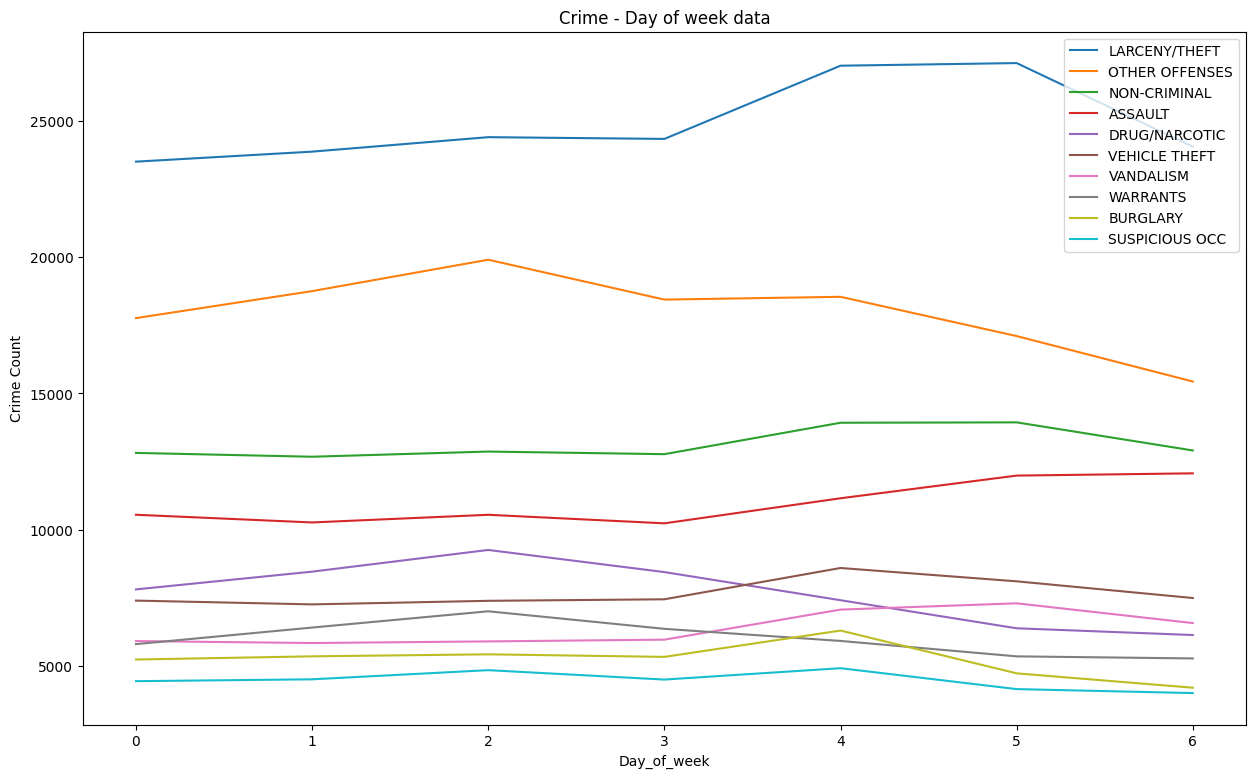

In [52]:
plt.figure(figsize = (15,9))

for crime in top_crimes['index']:
    df_cat = df1[df1.Category == crime].Day_Week.value_counts().to_frame().sort_index()
    plt.plot(df_cat)

plt.legend(list(top_crimes['index'].values))
plt.xlabel('Day_of_week')
plt.ylabel('Crime Count')
plt.title('Crime - Day of week data')

In [54]:
year_df = df1.Year.value_counts().to_frame().sort_index()
year_df.head(10)

,Year
2003,73744
2004,73201
2005,70596
2006,69713
2007,67841
2008,69976
2009,68771
2010,66354
2011,66475
2012,71558


Text(0.5, 1.0, 'Crime - Yearly data')

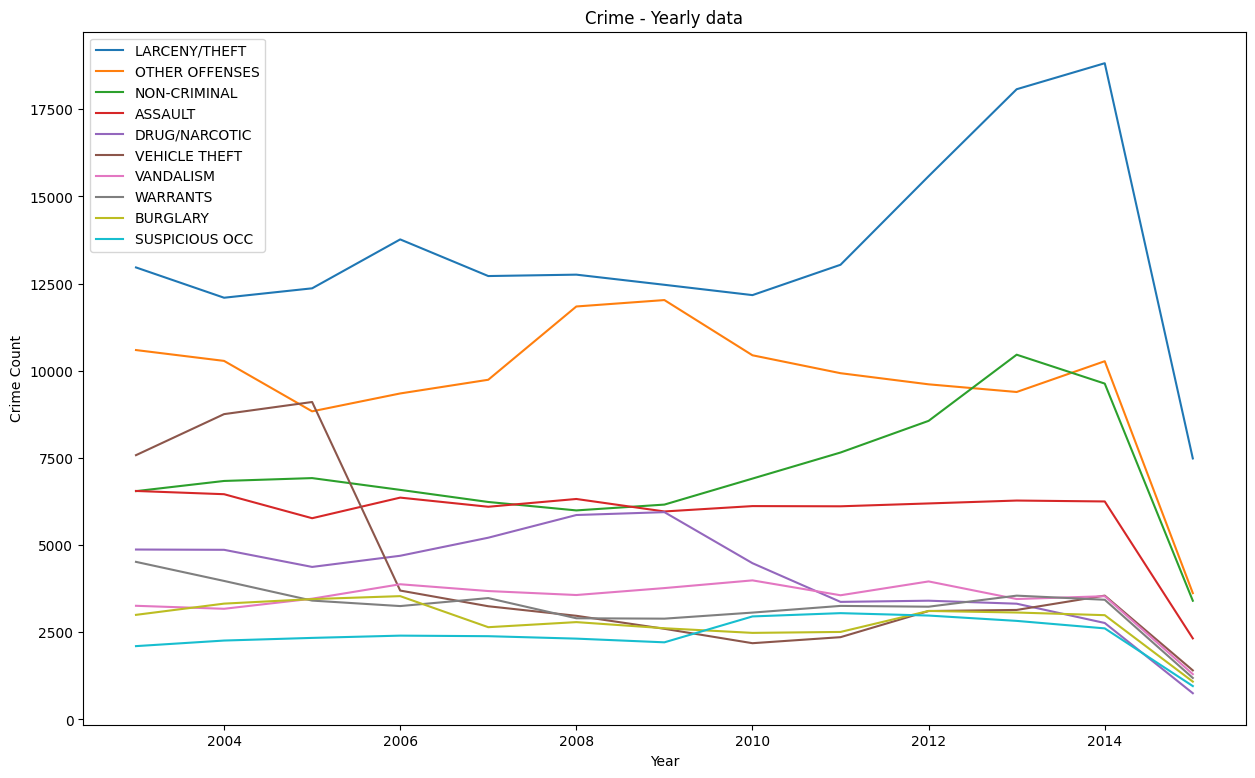

In [55]:
plt.figure(figsize = (15,9))

for crime in top_crimes['index']:
    df_cat = df1[df1.Category == crime].Year.value_counts().to_frame().sort_index()
    plt.plot(df_cat)

plt.legend(list(top_crimes['index'].values))
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Crime - Yearly data')

<AxesSubplot: xlabel='PdDistrict', ylabel='Category'>

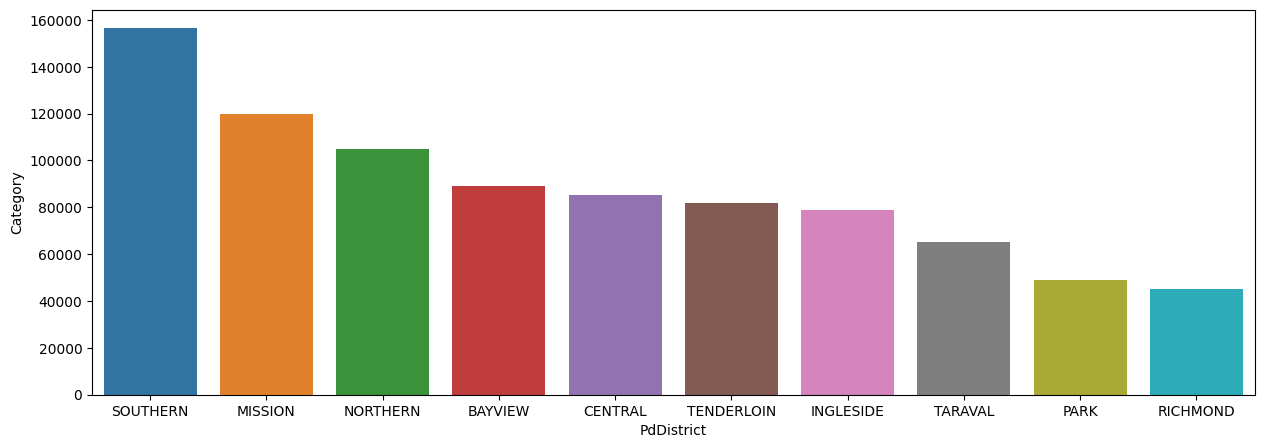

In [56]:
df2 = df1.groupby('PdDistrict').count().reset_index()[['PdDistrict','Category']].sort_values('Category', ascending = False)
plt.figure(figsize = (15,5))
sns.barplot(x = 'PdDistrict', y = 'Category', data = df2)

# 4. Data Preprocessing

In [66]:
df2 = df1.copy()

In [58]:
df1.Descript.nunique()

879

In [61]:
df3 = df1.Descript.value_counts().to_frame()
df3

,Descript
GRAND THEFT FROM LOCKED AUTO,59765
LOST PROPERTY,31498
BATTERY,27417
STOLEN AUTOMOBILE,26866
"DRIVERS LICENSE, SUSPENDED OR REVOKED",26823
...,...
FALSE REPORT OF POLICE MISCONDUCT,1
"HAZARDOUS MATERIALS, DUMP OIL INTO SEWERS",1
"ASSAULT, AGGRAVATED, ON POLICE OFFICER, W/ SEMI AUTO",1
"ROBBERY, VEHICLE FOR HIRE, ATT., W/ GUN",1


In [63]:
df3[df3['Descript'] < 100]

,Descript
ROBBERY OF A SERVICE STATION WITH A GUN,98
FORGE OR ALTER PRESCRIPTION,98
SODOMY,97
"LICENSE PLATE, FOUND",97
"KIDNAPPING, JUVENILE VICTIM",96
...,...
FALSE REPORT OF POLICE MISCONDUCT,1
"HAZARDOUS MATERIALS, DUMP OIL INTO SEWERS",1
"ASSAULT, AGGRAVATED, ON POLICE OFFICER, W/ SEMI AUTO",1
"ROBBERY, VEHICLE FOR HIRE, ATT., W/ GUN",1


In [62]:
df3[df3['Descript'] < 100].count()

Descript    515
dtype: int64

In [65]:
df3[df3['Descript'] < 100].index

Index(['ROBBERY OF A SERVICE STATION WITH A GUN',
       'FORGE OR ALTER PRESCRIPTION', 'SODOMY', 'LICENSE PLATE, FOUND',
       'KIDNAPPING, JUVENILE VICTIM', 'SALE OF AMPHETAMINE',
       'SCHOOL PROPERTY, DISTURBANCE ON', 'INTOXICATED JUVENILE', 'PIMPING',
       'POSSESSION OF METHADONE',
       ...
       'ESCAPE FROM HOSPITAL WITH FORCE', 'SNIPER SCOPE, POSSESSION OF',
       'TERRORIZING BY MARKING PRIVATE PROPERTY', 'DRIVING, DRAG RACING',
       'PUBLIC UTILITY INFORMATION, FRAUDULENTLY OBTAINING',
       'FALSE REPORT OF POLICE MISCONDUCT',
       'HAZARDOUS MATERIALS, DUMP OIL INTO SEWERS',
       'ASSAULT, AGGRAVATED, ON POLICE OFFICER, W/ SEMI AUTO',
       'ROBBERY, VEHICLE FOR HIRE, ATT., W/ GUN',
       'EMBEZZLEMENT, GRAND THEFT PUBLIC/PRIVATE OFFICIAL'],
      dtype='object', length=515)

In [67]:
df2['Descript'] = df2['Descript'].apply(lambda x: 'other' if x in df3[df3['Descript'] < 100].index else x)

In [68]:
df2['Descript'].nunique()

365

In [69]:
x = df2.drop(['Category', 'Address'], axis = 1)
y = df2['Category']

In [70]:
dummy_df = pd.get_dummies(x[['Descript', 'PdDistrict', 'Resolution']])
dummy_df

,Descript_ABANDONMENT OF CHILD,"Descript_ACCESS CARD INFORMATION, THEFT OF",Descript_ACTS AGAINST PUBLIC TRANSIT,"Descript_AGGRAVATED ASSAULT OF POLICE OFFICER,BODILY FORCE",Descript_AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Descript_AGGRAVATED ASSAULT WITH A GUN,Descript_AGGRAVATED ASSAULT WITH A KNIFE,Descript_AGGRAVATED ASSAULT WITH BODILY FORCE,Descript_AGGRESSIVE SOLICITING,Descript_AIDED CASE,...,Resolution_JUVENILE BOOKED,Resolution_JUVENILE CITED,Resolution_JUVENILE DIVERTED,Resolution_LOCATED,Resolution_NONE,Resolution_NOT PROSECUTED,Resolution_PROSECUTED BY OUTSIDE AGENCY,Resolution_PROSECUTED FOR LESSER OFFENSE,Resolution_PSYCHOPATHIC CASE,Resolution_UNFOUNDED
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
878045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
878046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
878047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [71]:
x = x.drop(['Descript', 'PdDistrict', 'Resolution'],axis = 1)

In [72]:
X = pd.concat([x,dummy_df], axis = 1)

In [73]:
X.shape

(875726, 399)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [76]:
print('x train :', x_train.shape,'\t\tx test :', x_test.shape)
print('y train :', y_train.shape,'\t\ty test :', y_test.shape)


x train : (656794, 399) 		x test : (218932, 399)
y train : (656794,) 		y test : (218932,)


In [80]:
# KNN model

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

print('Accuracy score of KNN model :', accuracy_score(y_pred, y_test))

Accuracy score of KNN model : 0.4297909853287779


In [81]:
# Random forest classifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

print('Accuracy score of RFC model :', accuracy_score(y_pred, y_test))

Accuracy score of RFC model : 0.988073922496483


In [82]:
# Decision Tree

dtc = DecisionTreeClassifier(random_state= 1)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)

print('Accuracy score of DTC model :', accuracy_score(y_pred, y_test))

Accuracy score of DTC model : 0.9871740997204611
